In [4]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm import tqdm

In [61]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root='dataset_1500', transform=transform)
print(dataset.class_to_idx)
print(len(dataset))

dataset_loader = DataLoader(dataset, batch_size=32, shuffle=False)

mean = 0.0
std = 0.0

for images, _ in dataset_loader:
    mean += images.mean([0, 2, 3])
    std += images.std([0, 2, 3])

mean /= len(dataset_loader)
std /= len(dataset_loader)
print(f"Mean: {mean}, Std: {std}")

{'red-billed-blue-magpie': 0, 'taiwan-blue-magpie': 1, 'yellow-billed-blue-magpie': 2}
4500
Mean: tensor([0.4649, 0.4851, 0.4108]), Std: tensor([0.2307, 0.2293, 0.2464])


In [44]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root='dataset_1500', transform=transform)
print(dataset.class_to_idx)
print(len(dataset))

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = int(0.15 * len(dataset))
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_dataset = train_dataset.dataset
val_dataset = val_dataset.dataset
test_dataset = test_dataset.dataset

if not os.path.exists('dataset'):
    os.makedirs('dataset')

torch.save(train_dataset, 'dataset/train_dataset.pt')
torch.save(val_dataset, 'dataset/val_dataset.pt')
torch.save(test_dataset, 'dataset/test_dataset.pt')

{'red-billed-blue-magpie': 0, 'taiwan-blue-magpie': 1, 'yellow-billed-blue-magpie': 2}
4500


In [70]:
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    # transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.2)),
    transforms.Normalize(mean=[0.4649, 0.4851, 0.4108], std=[0.2307, 0.2293, 0.2464]),
])

normalize_transform = transforms.Compose([
    transforms.Normalize(mean=[0.4649, 0.4851, 0.4108], std=[0.2307, 0.2293, 0.2464]),
])

# apply other transformations to the dataset
class CustomDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [71]:
train_dataset = torch.load('dataset/train_dataset.pt')
val_dataset = torch.load('dataset/val_dataset.pt')
test_dataset = torch.load('dataset/test_dataset.pt')

# create dataloader
augmentation_train_dataset = CustomDatasetWrapper(train_dataset, transform=augmentation_transform)
train_loader = DataLoader(augmentation_train_dataset, batch_size=32, shuffle=True)

val_dataset = CustomDatasetWrapper(val_dataset, transform=normalize_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDatasetWrapper(test_dataset, transform=normalize_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# check dataset size
print('train dataset size:', len(train_dataset))
print('val dataset size:', len(val_dataset))
print('test dataset size:', len(test_dataset))

for x, y in train_loader:
    print(x.shape, y.shape)
    break

train dataset size: 4500
val dataset size: 4500
test dataset size: 4500
torch.Size([32, 3, 256, 256]) torch.Size([32])


/var/folders/c9/3dhl203d2k3g_d2pnb4cvpvr0000gn/T/ipykernel_98238/734293549.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load('dataset/train_data

In [72]:
mean = 0.0
std = 0.0

for images, _ in train_loader:
    mean += images.mean([0, 2, 3])
    std += images.std([0, 2, 3])

for images, _ in val_loader:
    mean += images.mean([0, 2, 3])
    std += images.std([0, 2, 3])

for images, _ in test_loader:
    mean += images.mean([0, 2, 3])
    std += images.std([0, 2, 3])

mean /= len(train_loader) + len(val_loader) + len(test_loader)
std /= len(train_loader) + len(val_loader) + len(test_loader)

# mean /= len(train_loader)
# std /= len(train_loader)

print(f"Mean: {mean}, Std: {std}")

Mean: tensor([-0.0001, -0.0002, -0.0004]), Std: tensor([1.0034, 1.0061, 1.0045])


{0: 'red-billed-blue-magpie', 1: 'taiwan-blue-magpie', 2: 'yellow-billed-blue-magpie'}


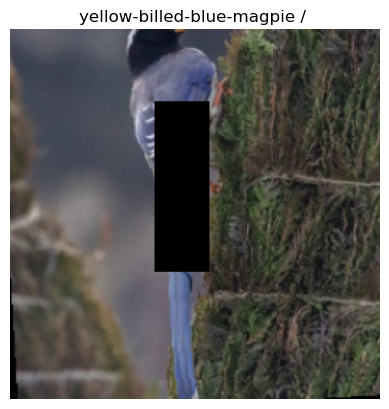

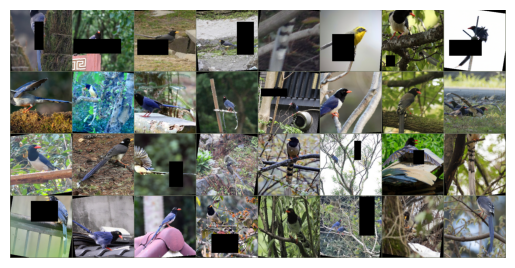

In [42]:
# labels map
label_map = {v: k for k, v in train_dataset.class_to_idx.items()}
print(label_map)

# define mean and std of the dataset
mean = [0.4659, 0.4855, 0.4103]
std = [0.2317, 0.2310, 0.2473]

# denormalize transform
denormalize_transform = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

# show images
def show_singel_image(image, label, pred=None):
    image = denormalize_transform(image)
    npimg = image.permute(1, 2, 0).numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)
    plt.axis('off')
    plt.title(label_map[label] + ' / ' + (label_map[pred] if pred is not None else ''))
    plt.show()

def show_multiple_images(images):
    images = denormalize_transform(images)
    images = torchvision.utils.make_grid(images, nrow=8)
    npimg = images.permute(1, 2, 0).numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()

for img, label in train_loader:
    show_singel_image(img[0], label[0].item())
    show_multiple_images(torchvision.utils.make_grid(img, nrow=8))
    break

In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('device:', device)

device: mps


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # conv 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        # 256 x 256 -> 128 x 128
        
        # conv 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        # 128 x 128 -> 64 x 64
        
        # conv 3
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        # 64 x 64 -> 32 x 32

        # conv 4
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, 2)
        # 32 x 32 -> 16 x 16

        # conv 5
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(2, 2)
        # 16 x 16 -> 8 x 8
        
        # 全連接層
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 120)
        self.fc4 = nn.Linear(120, 3)

        # Dropout 層
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = self.pool5(self.relu5(self.conv5(x)))
        x = x.view(-1, 512 * 8 * 8)
        x = self.dropout(self.relu4(self.fc1(x)))
        x = self.dropout(self.relu4(self.fc2(x)))
        x = self.dropout(self.relu4(self.fc3(x)))
        x = self.fc4(x)

        return x

# 初始化模型
model = SimpleCNN()
model.to(device)
# summary(model, input_size=(32, 3, 256, 256))

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=1024, bias=True)
  (fc2): Linear

In [29]:
# # use existing model
# model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
# # layers = list(model.children())[:-1]
# # summary(model, input_size=(32, 3, 256, 256))
# # layers = list(model.children())[:-1]


# num_ftrs = model.fc.in_features
# model.fc = torch.nn.Linear(num_ftrs, 3)
# summary(model, input_size=(32, 3, 256, 256))
# model = model.to(device)

In [30]:
# optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [33]:
# training loop
def train(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_loss = []
    val_loss = []
    val_acc = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss.append(running_loss / len(train_loader))
        print(f'epoch: {epoch + 1}, train loss: {train_loss[-1]}')
        
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for x, y in tqdm(val_loader):
                x, y = x.to(device), y.to(device)
                y_hat = model(x)
                loss = criterion(y_hat, y)
                running_loss += loss.item()
                _, predicted = torch.max(y_hat, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        if len(val_acc) == 0 or correct / total > max(val_acc):
            torch.save(model.state_dict(), 'ckpt/simpleCNN.pth')
        
        val_loss.append(running_loss / len(val_loader))
        val_acc.append(correct / total)
        print(f'epoch: {epoch + 1}, val loss: {val_loss[-1]}, val acc: {val_acc[-1]}')

    return train_loss, val_loss, val_acc

In [34]:
# train model
train_loss, val_loss, val_acc = train(model, train_loader, val_loader, optimizer, criterion, epochs=200)

100%|██████████| 99/99 [00:29<00:00,  3.31it/s]


epoch: 1, train loss: 1.070309406579143


100%|██████████| 22/22 [00:02<00:00,  8.16it/s]


epoch: 1, val loss: 1.046916587786241, val acc: 0.43407407407407406


100%|██████████| 99/99 [00:28<00:00,  3.42it/s]


epoch: 2, train loss: 1.053942570782671


100%|██████████| 22/22 [00:02<00:00,  8.43it/s]


epoch: 2, val loss: 1.0453453172336926, val acc: 0.44592592592592595


100%|██████████| 99/99 [00:29<00:00,  3.41it/s]


epoch: 3, train loss: 1.0292447022717408


100%|██████████| 22/22 [00:02<00:00,  8.37it/s]


epoch: 3, val loss: 1.0440650663592599, val acc: 0.45185185185185184


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


epoch: 4, train loss: 1.0042982396453317


100%|██████████| 22/22 [00:02<00:00,  8.43it/s]


epoch: 4, val loss: 0.9144182123921134, val acc: 0.5837037037037037


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


epoch: 5, train loss: 0.9023211231135359


100%|██████████| 22/22 [00:02<00:00,  8.35it/s]


epoch: 5, val loss: 0.7943283129822124, val acc: 0.6148148148148148


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


epoch: 6, train loss: 0.7909685842918627


100%|██████████| 22/22 [00:02<00:00,  8.46it/s]


epoch: 6, val loss: 0.7922728847373616, val acc: 0.642962962962963


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


epoch: 7, train loss: 0.7325655068411971


100%|██████████| 22/22 [00:02<00:00,  8.40it/s]


epoch: 7, val loss: 0.7557087648998607, val acc: 0.674074074074074


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


epoch: 8, train loss: 0.657163282536497


100%|██████████| 22/22 [00:02<00:00,  8.35it/s]


epoch: 8, val loss: 0.6873524717309258, val acc: 0.6903703703703704


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


epoch: 9, train loss: 0.6156740411363467


100%|██████████| 22/22 [00:02<00:00,  8.38it/s]


epoch: 9, val loss: 0.6753451390699907, val acc: 0.725925925925926


100%|██████████| 99/99 [00:28<00:00,  3.45it/s]


epoch: 10, train loss: 0.5472222988051597


100%|██████████| 22/22 [00:02<00:00,  8.44it/s]


epoch: 10, val loss: 0.7815655226057227, val acc: 0.6903703703703704


100%|██████████| 99/99 [00:28<00:00,  3.44it/s]


epoch: 11, train loss: 0.48611272495202346


100%|██████████| 22/22 [00:02<00:00,  8.17it/s]


epoch: 11, val loss: 0.8030110055750067, val acc: 0.7140740740740741


100%|██████████| 99/99 [00:29<00:00,  3.32it/s]


epoch: 12, train loss: 0.41677050744042254


100%|██████████| 22/22 [00:02<00:00,  8.27it/s]


epoch: 12, val loss: 0.7846060408787294, val acc: 0.7244444444444444


100%|██████████| 99/99 [00:29<00:00,  3.41it/s]


epoch: 13, train loss: 0.3321542385401148


100%|██████████| 22/22 [00:02<00:00,  7.98it/s]


epoch: 13, val loss: 0.8891918509351936, val acc: 0.7051851851851851


100%|██████████| 99/99 [00:28<00:00,  3.43it/s]


epoch: 14, train loss: 0.3039933467904727


100%|██████████| 22/22 [00:02<00:00,  8.41it/s]


epoch: 14, val loss: 1.3750282702120868, val acc: 0.7274074074074074


100%|██████████| 99/99 [00:29<00:00,  3.34it/s]


epoch: 15, train loss: 0.24819257087779767


100%|██████████| 22/22 [00:02<00:00,  7.81it/s]


epoch: 15, val loss: 1.2339990694414487, val acc: 0.7022222222222222


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]


epoch: 16, train loss: 0.2132269718656034


100%|██████████| 22/22 [00:02<00:00,  7.93it/s]


epoch: 16, val loss: 1.27596765011549, val acc: 0.7081481481481482


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]


epoch: 17, train loss: 0.22347789743181432


100%|██████████| 22/22 [00:02<00:00,  7.91it/s]


epoch: 17, val loss: 1.4049648073586551, val acc: 0.7229629629629629


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]


epoch: 18, train loss: 0.14904853961232936


100%|██████████| 22/22 [00:02<00:00,  8.14it/s]


epoch: 18, val loss: 1.702179342508316, val acc: 0.7081481481481482


100%|██████████| 99/99 [00:29<00:00,  3.34it/s]


epoch: 19, train loss: 0.15197011835948385


100%|██████████| 22/22 [00:02<00:00,  8.04it/s]


epoch: 19, val loss: 1.4919792359525508, val acc: 0.7125925925925926


100%|██████████| 99/99 [00:29<00:00,  3.33it/s]


epoch: 20, train loss: 0.12697441097950996


100%|██████████| 22/22 [00:02<00:00,  8.00it/s]


epoch: 20, val loss: 1.8420833255037328, val acc: 0.7155555555555555


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]


epoch: 21, train loss: 0.08973290898479672


100%|██████████| 22/22 [00:02<00:00,  7.98it/s]


epoch: 21, val loss: 2.2758568823337555, val acc: 0.7066666666666667


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 22, train loss: 0.12008156633766537


100%|██████████| 22/22 [00:02<00:00,  8.10it/s]


epoch: 22, val loss: 1.6284185512499376, val acc: 0.6903703703703704


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]


epoch: 23, train loss: 0.06880494266644949


100%|██████████| 22/22 [00:02<00:00,  8.11it/s]


epoch: 23, val loss: 2.437274019826542, val acc: 0.7022222222222222


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]


epoch: 24, train loss: 0.09997957314110616


100%|██████████| 22/22 [00:02<00:00,  7.70it/s]


epoch: 24, val loss: 1.7016085003587333, val acc: 0.7037037037037037


100%|██████████| 99/99 [00:29<00:00,  3.32it/s]


epoch: 25, train loss: 0.1147023586749165


100%|██████████| 22/22 [00:02<00:00,  8.11it/s]


epoch: 25, val loss: 1.7058163251389156, val acc: 0.7096296296296296


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]


epoch: 26, train loss: 0.051668527404392005


100%|██████████| 22/22 [00:03<00:00,  7.13it/s]


epoch: 26, val loss: 2.471409610726617, val acc: 0.7111111111111111


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]


epoch: 27, train loss: 0.052897250014028015


100%|██████████| 22/22 [00:02<00:00,  8.06it/s]


epoch: 27, val loss: 2.425351213324544, val acc: 0.7111111111111111


100%|██████████| 99/99 [00:30<00:00,  3.30it/s]


epoch: 28, train loss: 0.07218220184424556


100%|██████████| 22/22 [00:02<00:00,  8.04it/s]


epoch: 28, val loss: 2.0984114191748877, val acc: 0.6948148148148148


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 29, train loss: 0.02042138681964857


100%|██████████| 22/22 [00:02<00:00,  8.06it/s]


epoch: 29, val loss: 3.4537255545146763, val acc: 0.7111111111111111


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]


epoch: 30, train loss: 0.11973129032897607


100%|██████████| 22/22 [00:02<00:00,  8.06it/s]


epoch: 30, val loss: 1.9918879189274528, val acc: 0.7244444444444444


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]


epoch: 31, train loss: 0.051854084926125865


100%|██████████| 22/22 [00:02<00:00,  8.08it/s]


epoch: 31, val loss: 2.359454398805445, val acc: 0.7155555555555555


100%|██████████| 99/99 [00:29<00:00,  3.33it/s]


epoch: 32, train loss: 0.06741427089677973


100%|██████████| 22/22 [00:02<00:00,  8.08it/s]


epoch: 32, val loss: 2.7119937620379706, val acc: 0.677037037037037


100%|██████████| 99/99 [00:29<00:00,  3.34it/s]


epoch: 33, train loss: 0.048874612329668846


100%|██████████| 22/22 [00:02<00:00,  7.82it/s]


epoch: 33, val loss: 2.4134692793542687, val acc: 0.68


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]


epoch: 34, train loss: 0.050266681535338816


100%|██████████| 22/22 [00:02<00:00,  7.95it/s]


epoch: 34, val loss: 2.520766969770193, val acc: 0.7140740740740741


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]


epoch: 35, train loss: 0.024123907573158073


100%|██████████| 22/22 [00:02<00:00,  8.06it/s]


epoch: 35, val loss: 3.1986399320038883, val acc: 0.7303703703703703


100%|██████████| 99/99 [00:29<00:00,  3.34it/s]


epoch: 36, train loss: 0.05719721669938184


100%|██████████| 22/22 [00:02<00:00,  7.99it/s]


epoch: 36, val loss: 2.223665803670883, val acc: 0.7051851851851851


100%|██████████| 99/99 [00:29<00:00,  3.32it/s]


epoch: 37, train loss: 0.07325873272422927


100%|██████████| 22/22 [00:02<00:00,  8.04it/s]


epoch: 37, val loss: 2.2142439918084578, val acc: 0.7096296296296296


100%|██████████| 99/99 [00:29<00:00,  3.34it/s]


epoch: 38, train loss: 0.046140989850773806


100%|██████████| 22/22 [00:02<00:00,  8.07it/s]


epoch: 38, val loss: 2.1092578836462716, val acc: 0.7274074074074074


100%|██████████| 99/99 [00:29<00:00,  3.31it/s]


epoch: 39, train loss: 0.0344366907165474


100%|██████████| 22/22 [00:02<00:00,  8.01it/s]


epoch: 39, val loss: 2.342280935157429, val acc: 0.7096296296296296


100%|██████████| 99/99 [00:29<00:00,  3.31it/s]


epoch: 40, train loss: 0.03472917521617321


100%|██████████| 22/22 [00:02<00:00,  7.75it/s]


epoch: 40, val loss: 3.0088428285988895, val acc: 0.7244444444444444


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]


epoch: 41, train loss: 0.022599138793789234


100%|██████████| 22/22 [00:02<00:00,  8.01it/s]


epoch: 41, val loss: 3.510735511779785, val acc: 0.7214814814814815


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 42, train loss: 0.03625078804207813


100%|██████████| 22/22 [00:02<00:00,  8.15it/s]


epoch: 42, val loss: 2.4603469967812956, val acc: 0.7066666666666667


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 43, train loss: 0.030939400576336092


100%|██████████| 22/22 [00:02<00:00,  8.11it/s]


epoch: 43, val loss: 3.5036754445596174, val acc: 0.7051851851851851


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 44, train loss: 0.05075231240062758


100%|██████████| 22/22 [00:02<00:00,  8.30it/s]


epoch: 44, val loss: 3.0595575083385813, val acc: 0.7185185185185186


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 45, train loss: 0.08280558092901813


100%|██████████| 22/22 [00:02<00:00,  7.94it/s]


epoch: 45, val loss: 2.565326366912235, val acc: 0.6903703703703704


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 46, train loss: 0.07323661563751015


100%|██████████| 22/22 [00:02<00:00,  8.00it/s]


epoch: 46, val loss: 2.2771515250205994, val acc: 0.7214814814814815


100%|██████████| 99/99 [00:29<00:00,  3.34it/s]


epoch: 47, train loss: 0.022379317633014505


100%|██████████| 22/22 [00:02<00:00,  7.97it/s]


epoch: 47, val loss: 3.4282496463168752, val acc: 0.7348148148148148


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 48, train loss: 0.05950607135225319


100%|██████████| 22/22 [00:02<00:00,  7.85it/s]


epoch: 48, val loss: 2.208971866152503, val acc: 0.7066666666666667


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 49, train loss: 0.04687369349994697


100%|██████████| 22/22 [00:02<00:00,  7.95it/s]


epoch: 49, val loss: 2.6805488352071154, val acc: 0.7362962962962963


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 50, train loss: 0.06522261699549313


100%|██████████| 22/22 [00:02<00:00,  7.63it/s]


epoch: 50, val loss: 2.481304873119701, val acc: 0.6903703703703704


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 51, train loss: 0.02102718066056365


100%|██████████| 22/22 [00:02<00:00,  7.91it/s]


epoch: 51, val loss: 2.986989838494496, val acc: 0.7437037037037038


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 52, train loss: 0.050883984032624896


100%|██████████| 22/22 [00:02<00:00,  8.00it/s]


epoch: 52, val loss: 2.9217361320148814, val acc: 0.6903703703703704


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 53, train loss: 0.03183927824429794


100%|██████████| 22/22 [00:02<00:00,  7.62it/s]


epoch: 53, val loss: 3.7328446724198083, val acc: 0.6933333333333334


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 54, train loss: 0.013393069619431718


100%|██████████| 22/22 [00:02<00:00,  7.83it/s]


epoch: 54, val loss: 3.7851235433058306, val acc: 0.7333333333333333


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 55, train loss: 0.03516026850426134


100%|██████████| 22/22 [00:02<00:00,  8.08it/s]


epoch: 55, val loss: 2.7288333157782536, val acc: 0.7155555555555555


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 56, train loss: 0.07656189682070316


100%|██████████| 22/22 [00:02<00:00,  8.24it/s]


epoch: 56, val loss: 2.9127893434329466, val acc: 0.6977777777777778


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 57, train loss: 0.045391591800653996


100%|██████████| 22/22 [00:02<00:00,  8.23it/s]


epoch: 57, val loss: 3.314151335846294, val acc: 0.7303703703703703


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 58, train loss: 0.022978733536868762


100%|██████████| 22/22 [00:02<00:00,  8.21it/s]


epoch: 58, val loss: 3.742880203507163, val acc: 0.7125925925925926


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 59, train loss: 0.07969793166032767


100%|██████████| 22/22 [00:02<00:00,  8.07it/s]


epoch: 59, val loss: 2.143549803305756, val acc: 0.6814814814814815


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 60, train loss: 0.02992703272838932


100%|██████████| 22/22 [00:02<00:00,  8.03it/s]


epoch: 60, val loss: 2.8455913471228667, val acc: 0.7037037037037037


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 61, train loss: 0.05680778129118897


100%|██████████| 22/22 [00:02<00:00,  8.14it/s]


epoch: 61, val loss: 2.1815794597972524, val acc: 0.7022222222222222


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 62, train loss: 0.034478652174988786


100%|██████████| 22/22 [00:02<00:00,  8.12it/s]


epoch: 62, val loss: 3.075097777626731, val acc: 0.6859259259259259


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 63, train loss: 0.06415002200384436


100%|██████████| 22/22 [00:02<00:00,  8.18it/s]


epoch: 63, val loss: 3.414872559634122, val acc: 0.674074074074074


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 64, train loss: 0.052203245626717236


100%|██████████| 22/22 [00:02<00:00,  8.18it/s]


epoch: 64, val loss: 3.1743431253866716, val acc: 0.6992592592592592


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 65, train loss: 0.005631516349666586


100%|██████████| 22/22 [00:02<00:00,  8.15it/s]


epoch: 65, val loss: 4.405890210108324, val acc: 0.6992592592592592


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 66, train loss: 0.02568123720904182


100%|██████████| 22/22 [00:02<00:00,  8.14it/s]


epoch: 66, val loss: 4.3325980576601895, val acc: 0.7155555555555555


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 67, train loss: 0.03870109538281277


100%|██████████| 22/22 [00:02<00:00,  8.13it/s]


epoch: 67, val loss: 2.918912027821396, val acc: 0.6962962962962963


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 68, train loss: 0.019610546632718225


100%|██████████| 22/22 [00:02<00:00,  8.14it/s]


epoch: 68, val loss: 3.8731004270640286, val acc: 0.6948148148148148


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 69, train loss: 0.036945651428958615


100%|██████████| 22/22 [00:02<00:00,  8.17it/s]


epoch: 69, val loss: 3.4872796535491943, val acc: 0.7081481481481482


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]


epoch: 70, train loss: 0.047371830915771435


100%|██████████| 22/22 [00:02<00:00,  8.08it/s]


epoch: 70, val loss: 2.7597477833429953, val acc: 0.7244444444444444


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 71, train loss: 0.013637087785749279


100%|██████████| 22/22 [00:02<00:00,  8.20it/s]


epoch: 71, val loss: 4.276216040958058, val acc: 0.7037037037037037


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 72, train loss: 0.019090809747371113


100%|██████████| 22/22 [00:02<00:00,  8.09it/s]


epoch: 72, val loss: 3.370330829808319, val acc: 0.7081481481481482


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 73, train loss: 0.08421640045693346


100%|██████████| 22/22 [00:02<00:00,  8.03it/s]


epoch: 73, val loss: 2.880544946274974, val acc: 0.6711111111111111


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 74, train loss: 0.03301382392705956


100%|██████████| 22/22 [00:02<00:00,  8.00it/s]


epoch: 74, val loss: 3.3981932510029185, val acc: 0.7274074074074074


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 75, train loss: 0.004396062369178075


100%|██████████| 22/22 [00:02<00:00,  8.01it/s]


epoch: 75, val loss: 5.003178294409405, val acc: 0.7288888888888889


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 76, train loss: 0.08804207995773242


100%|██████████| 22/22 [00:02<00:00,  8.02it/s]


epoch: 76, val loss: 3.12630126693032, val acc: 0.6918518518518518


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 77, train loss: 0.021525071984259823


100%|██████████| 22/22 [00:02<00:00,  7.96it/s]


epoch: 77, val loss: 5.220450829375874, val acc: 0.6814814814814815


100%|██████████| 99/99 [00:29<00:00,  3.40it/s]


epoch: 78, train loss: 0.04580118269111172


100%|██████████| 22/22 [00:02<00:00,  7.60it/s]


epoch: 78, val loss: 3.1008418798446655, val acc: 0.7007407407407408


100%|██████████| 99/99 [00:29<00:00,  3.31it/s]


epoch: 79, train loss: 0.009742425294979916


100%|██████████| 22/22 [00:02<00:00,  8.08it/s]


epoch: 79, val loss: 7.038166371258822, val acc: 0.6577777777777778


100%|██████████| 99/99 [00:29<00:00,  3.40it/s]


epoch: 80, train loss: 0.05845920353310749


100%|██████████| 22/22 [00:02<00:00,  8.08it/s]


epoch: 80, val loss: 3.192658906633204, val acc: 0.717037037037037


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 81, train loss: 0.05078365505286539


100%|██████████| 22/22 [00:02<00:00,  7.85it/s]


epoch: 81, val loss: 3.2313484007661994, val acc: 0.7125925925925926


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 82, train loss: 0.04142139173398556


100%|██████████| 22/22 [00:02<00:00,  8.19it/s]


epoch: 82, val loss: 3.83530700748617, val acc: 0.6918518518518518


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 83, train loss: 0.046307303675187754


100%|██████████| 22/22 [00:02<00:00,  8.09it/s]


epoch: 83, val loss: 2.663090307604183, val acc: 0.7051851851851851


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 84, train loss: 0.04627364345162847


100%|██████████| 22/22 [00:02<00:00,  8.11it/s]


epoch: 84, val loss: 1.9457572590221057, val acc: 0.6992592592592592


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 85, train loss: 0.018424237107741315


100%|██████████| 22/22 [00:02<00:00,  8.15it/s]


epoch: 85, val loss: 3.4767027009617197, val acc: 0.7007407407407408


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 86, train loss: 0.028064319512060423


100%|██████████| 22/22 [00:02<00:00,  8.04it/s]


epoch: 86, val loss: 3.2919710061766883, val acc: 0.7274074074074074


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 87, train loss: 0.013838249576413275


100%|██████████| 22/22 [00:02<00:00,  8.22it/s]


epoch: 87, val loss: 3.729288019917228, val acc: 0.7333333333333333


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 88, train loss: 0.07991868256241022


100%|██████████| 22/22 [00:02<00:00,  7.71it/s]


epoch: 88, val loss: 2.6814655572975012, val acc: 0.6607407407407407


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 89, train loss: 0.05563861447180071


100%|██████████| 22/22 [00:02<00:00,  8.14it/s]


epoch: 89, val loss: 2.8314602808518843, val acc: 0.7111111111111111


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 90, train loss: 0.05115470398805249


100%|██████████| 22/22 [00:02<00:00,  8.18it/s]


epoch: 90, val loss: 2.2906049977649343, val acc: 0.7437037037037038


100%|██████████| 99/99 [00:29<00:00,  3.33it/s]


epoch: 91, train loss: 0.03483513173452795


100%|██████████| 22/22 [00:02<00:00,  8.09it/s]


epoch: 91, val loss: 2.9703824628483164, val acc: 0.7377777777777778


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 92, train loss: 0.037617032957846484


100%|██████████| 22/22 [00:02<00:00,  8.15it/s]


epoch: 92, val loss: 3.1766664277423513, val acc: 0.7096296296296296


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 93, train loss: 0.08915902734459984


100%|██████████| 22/22 [00:02<00:00,  8.20it/s]


epoch: 93, val loss: 2.756115062670274, val acc: 0.7037037037037037


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 94, train loss: 0.04577278781220106


100%|██████████| 22/22 [00:02<00:00,  8.19it/s]


epoch: 94, val loss: 3.692468924955888, val acc: 0.72


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 95, train loss: 0.0285298815908221


100%|██████████| 22/22 [00:02<00:00,  8.06it/s]


epoch: 95, val loss: 3.331684036688371, val acc: 0.7022222222222222


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 96, train loss: 0.027936423422316337


100%|██████████| 22/22 [00:02<00:00,  8.20it/s]


epoch: 96, val loss: 3.567670930515636, val acc: 0.7185185185185186


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 97, train loss: 0.011135038557910093


100%|██████████| 22/22 [00:02<00:00,  8.09it/s]


epoch: 97, val loss: 4.321908371015028, val acc: 0.6962962962962963


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 98, train loss: 0.00637641310072037


100%|██████████| 22/22 [00:02<00:00,  8.17it/s]


epoch: 98, val loss: 4.127429236065257, val acc: 0.6948148148148148


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 99, train loss: 0.014120100096071864


100%|██████████| 22/22 [00:02<00:00,  8.12it/s]


epoch: 99, val loss: 4.527336326512423, val acc: 0.7007407407407408


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 100, train loss: 0.013045108200333173


100%|██████████| 22/22 [00:02<00:00,  8.21it/s]


epoch: 100, val loss: 3.8650679385120217, val acc: 0.7185185185185186


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 101, train loss: 0.003084676926029622


100%|██████████| 22/22 [00:02<00:00,  8.11it/s]


epoch: 101, val loss: 6.036054882136258, val acc: 0.7274074074074074


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 102, train loss: 0.02768568596442029


100%|██████████| 22/22 [00:02<00:00,  8.18it/s]


epoch: 102, val loss: 5.653561559590426, val acc: 0.7022222222222222


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 103, train loss: 0.011388425996690092


100%|██████████| 22/22 [00:02<00:00,  8.17it/s]


epoch: 103, val loss: 4.193795930255543, val acc: 0.7051851851851851


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 104, train loss: 0.01918861828128091


100%|██████████| 22/22 [00:02<00:00,  8.11it/s]


epoch: 104, val loss: 4.922753881324422, val acc: 0.7096296296296296


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 105, train loss: 0.03486034434175642


100%|██████████| 22/22 [00:02<00:00,  8.24it/s]


epoch: 105, val loss: 3.939251119440252, val acc: 0.68


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 106, train loss: 0.027166334406892267


100%|██████████| 22/22 [00:02<00:00,  8.13it/s]


epoch: 106, val loss: 4.508813272822987, val acc: 0.717037037037037


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 107, train loss: 0.020407756571060674


100%|██████████| 22/22 [00:02<00:00,  8.09it/s]


epoch: 107, val loss: 4.145094443451274, val acc: 0.7274074074074074


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 108, train loss: 0.04789629060747468


100%|██████████| 22/22 [00:02<00:00,  8.10it/s]


epoch: 108, val loss: 3.479921953921968, val acc: 0.6844444444444444


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 109, train loss: 0.03440292759276215


100%|██████████| 22/22 [00:02<00:00,  8.20it/s]


epoch: 109, val loss: 4.147894891825589, val acc: 0.6814814814814815


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 110, train loss: 0.06787580576952228


100%|██████████| 22/22 [00:02<00:00,  8.14it/s]


epoch: 110, val loss: 3.128752651539716, val acc: 0.6755555555555556


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 111, train loss: 0.07092268522374622


100%|██████████| 22/22 [00:02<00:00,  7.89it/s]


epoch: 111, val loss: 4.162244737148285, val acc: 0.6888888888888889


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 112, train loss: 0.008847938394418487


100%|██████████| 22/22 [00:02<00:00,  8.10it/s]


epoch: 112, val loss: 4.884838000391449, val acc: 0.6977777777777778


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 113, train loss: 0.006664267443717692


100%|██████████| 22/22 [00:02<00:00,  8.12it/s]


epoch: 113, val loss: 7.097784226590937, val acc: 0.7185185185185186


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 114, train loss: 0.048041956573990574


100%|██████████| 22/22 [00:02<00:00,  8.15it/s]


epoch: 114, val loss: 5.790244010023096, val acc: 0.6859259259259259


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 115, train loss: 0.04454759255734395


100%|██████████| 22/22 [00:02<00:00,  8.18it/s]


epoch: 115, val loss: 3.0820574146328523, val acc: 0.717037037037037


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 116, train loss: 0.0181928233996334


100%|██████████| 22/22 [00:02<00:00,  8.20it/s]


epoch: 116, val loss: 3.884767946871844, val acc: 0.6814814814814815


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 117, train loss: 0.009969715210316454


100%|██████████| 22/22 [00:02<00:00,  8.14it/s]


epoch: 117, val loss: 4.784783460877159, val acc: 0.7125925925925926


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 118, train loss: 0.0016452977891863085


100%|██████████| 22/22 [00:02<00:00,  8.16it/s]


epoch: 118, val loss: 5.018681665241027, val acc: 0.7155555555555555


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 119, train loss: 0.004302275539464909


100%|██████████| 22/22 [00:02<00:00,  8.15it/s]


epoch: 119, val loss: 5.0131753141229805, val acc: 0.6962962962962963


100%|██████████| 99/99 [00:29<00:00,  3.33it/s]


epoch: 120, train loss: 0.016824536422942713


100%|██████████| 22/22 [00:02<00:00,  8.14it/s]


epoch: 120, val loss: 5.705374685200778, val acc: 0.6903703703703704


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 121, train loss: 0.06094236068050666


100%|██████████| 22/22 [00:02<00:00,  8.09it/s]


epoch: 121, val loss: 5.266442288051952, val acc: 0.7037037037037037


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]


epoch: 122, train loss: 0.07973088932730472


100%|██████████| 22/22 [00:02<00:00,  8.13it/s]


epoch: 122, val loss: 4.668815469199961, val acc: 0.7022222222222222


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 123, train loss: 0.05254035157258381


100%|██████████| 22/22 [00:02<00:00,  8.14it/s]


epoch: 123, val loss: 4.947099083685316, val acc: 0.6992592592592592


100%|██████████| 99/99 [00:29<00:00,  3.33it/s]


epoch: 124, train loss: 0.019718609955503435


100%|██████████| 22/22 [00:02<00:00,  8.10it/s]


epoch: 124, val loss: 4.601926771077243, val acc: 0.717037037037037


100%|██████████| 99/99 [00:29<00:00,  3.30it/s]


epoch: 125, train loss: 0.03072467738496411


100%|██████████| 22/22 [00:02<00:00,  7.84it/s]


epoch: 125, val loss: 3.4794067198579963, val acc: 0.717037037037037


100%|██████████| 99/99 [00:32<00:00,  3.02it/s]


epoch: 126, train loss: 0.0026743241846964656


100%|██████████| 22/22 [00:03<00:00,  6.64it/s]


epoch: 126, val loss: 4.626046641306444, val acc: 0.7185185185185186


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 127, train loss: 0.000919497272792261


100%|██████████| 22/22 [00:02<00:00,  8.20it/s]


epoch: 127, val loss: 5.273621223149927, val acc: 0.7288888888888889


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 128, train loss: 0.000850299839703124


100%|██████████| 22/22 [00:02<00:00,  8.13it/s]


epoch: 128, val loss: 6.6963170170784, val acc: 0.7229629629629629


100%|██████████| 99/99 [00:30<00:00,  3.25it/s]


epoch: 129, train loss: 0.005213213209493709


100%|██████████| 22/22 [00:02<00:00,  8.23it/s]


epoch: 129, val loss: 5.94384997270324, val acc: 0.7022222222222222


100%|██████████| 99/99 [00:29<00:00,  3.31it/s]


epoch: 130, train loss: 0.08352078563042524


100%|██████████| 22/22 [00:02<00:00,  8.25it/s]


epoch: 130, val loss: 3.6856673539362172, val acc: 0.717037037037037


100%|██████████| 99/99 [00:30<00:00,  3.27it/s]


epoch: 131, train loss: 0.013582752507340378


100%|██████████| 22/22 [00:02<00:00,  8.03it/s]


epoch: 131, val loss: 4.189776413330616, val acc: 0.7229629629629629


100%|██████████| 99/99 [00:29<00:00,  3.40it/s]


epoch: 132, train loss: 0.015547993780419234


100%|██████████| 22/22 [00:02<00:00,  8.23it/s]


epoch: 132, val loss: 4.488059562260539, val acc: 0.7096296296296296


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 133, train loss: 0.03954286347964698


100%|██████████| 22/22 [00:02<00:00,  8.32it/s]


epoch: 133, val loss: 4.2566585107283155, val acc: 0.677037037037037


100%|██████████| 99/99 [00:29<00:00,  3.40it/s]


epoch: 134, train loss: 0.12464651370141332


100%|██████████| 22/22 [00:02<00:00,  8.28it/s]


epoch: 134, val loss: 3.2989244637164203, val acc: 0.6592592592592592


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 135, train loss: 0.07144906320835223


100%|██████████| 22/22 [00:02<00:00,  8.19it/s]


epoch: 135, val loss: 3.8585024123842064, val acc: 0.6903703703703704


100%|██████████| 99/99 [00:29<00:00,  3.34it/s]


epoch: 136, train loss: 0.03152166471861568


100%|██████████| 22/22 [00:02<00:00,  8.11it/s]


epoch: 136, val loss: 4.043500629338351, val acc: 0.7007407407407408


100%|██████████| 99/99 [00:30<00:00,  3.29it/s]


epoch: 137, train loss: 0.010793196814270016


100%|██████████| 22/22 [00:02<00:00,  7.56it/s]


epoch: 137, val loss: 4.184950157999992, val acc: 0.7140740740740741


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 138, train loss: 0.021776292354573026


100%|██████████| 22/22 [00:02<00:00,  8.02it/s]


epoch: 138, val loss: 5.761225310238925, val acc: 0.7125925925925926


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 139, train loss: 0.04435010669090763


100%|██████████| 22/22 [00:02<00:00,  8.16it/s]


epoch: 139, val loss: 3.843595103784041, val acc: 0.6844444444444444


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 140, train loss: 0.014144288177638256


100%|██████████| 22/22 [00:02<00:00,  7.96it/s]


epoch: 140, val loss: 4.837168769402937, val acc: 0.7051851851851851


100%|██████████| 99/99 [00:29<00:00,  3.41it/s]


epoch: 141, train loss: 0.03369815658580051


100%|██████████| 22/22 [00:02<00:00,  8.29it/s]


epoch: 141, val loss: 3.237676036290147, val acc: 0.7051851851851851


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 142, train loss: 0.01256150598689645


100%|██████████| 22/22 [00:02<00:00,  8.16it/s]


epoch: 142, val loss: 5.188096601008014, val acc: 0.7214814814814815


100%|██████████| 99/99 [00:29<00:00,  3.40it/s]


epoch: 143, train loss: 0.016124800070916018


100%|██████████| 22/22 [00:02<00:00,  8.31it/s]


epoch: 143, val loss: 6.711823306300423, val acc: 0.7274074074074074


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 144, train loss: 0.03177594175206963


100%|██████████| 22/22 [00:02<00:00,  8.17it/s]


epoch: 144, val loss: 4.604570984840393, val acc: 0.6977777777777778


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 145, train loss: 0.013471397712323925


100%|██████████| 22/22 [00:02<00:00,  8.01it/s]


epoch: 145, val loss: 6.101956248283386, val acc: 0.7214814814814815


100%|██████████| 99/99 [00:29<00:00,  3.40it/s]


epoch: 146, train loss: 0.15183447295059507


100%|██████████| 22/22 [00:02<00:00,  8.23it/s]


epoch: 146, val loss: 3.5521183718334544, val acc: 0.72


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 147, train loss: 0.030541421597659435


100%|██████████| 22/22 [00:02<00:00,  8.26it/s]


epoch: 147, val loss: 3.8468950906323944, val acc: 0.7081481481481482


100%|██████████| 99/99 [00:29<00:00,  3.40it/s]


epoch: 148, train loss: 0.022668354636996388


100%|██████████| 22/22 [00:02<00:00,  8.21it/s]


epoch: 148, val loss: 4.402205793017691, val acc: 0.7081481481481482


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 149, train loss: 0.0222343182034352


100%|██████████| 22/22 [00:02<00:00,  8.23it/s]


epoch: 149, val loss: 5.556850102814761, val acc: 0.725925925925926


100%|██████████| 99/99 [00:29<00:00,  3.34it/s]


epoch: 150, train loss: 0.009559288211749683


100%|██████████| 22/22 [00:02<00:00,  8.14it/s]


epoch: 150, val loss: 5.673778620633212, val acc: 0.7185185185185186


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 151, train loss: 0.016143981939634938


100%|██████████| 22/22 [00:02<00:00,  8.25it/s]


epoch: 151, val loss: 5.166925663297826, val acc: 0.7274074074074074


100%|██████████| 99/99 [00:29<00:00,  3.32it/s]


epoch: 152, train loss: 0.010164719110867583


100%|██████████| 22/22 [00:02<00:00,  8.06it/s]


epoch: 152, val loss: 5.267401511696252, val acc: 0.7229629629629629


100%|██████████| 99/99 [00:29<00:00,  3.34it/s]


epoch: 153, train loss: 0.018405635957124404


100%|██████████| 22/22 [00:02<00:00,  8.18it/s]


epoch: 153, val loss: 6.480202176354148, val acc: 0.674074074074074


100%|██████████| 99/99 [00:29<00:00,  3.40it/s]


epoch: 154, train loss: 0.06543429151343207


100%|██████████| 22/22 [00:02<00:00,  8.24it/s]


epoch: 154, val loss: 4.705232739448547, val acc: 0.7140740740740741


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 155, train loss: 0.030004162295762114


100%|██████████| 22/22 [00:02<00:00,  8.34it/s]


epoch: 155, val loss: 4.767062544822693, val acc: 0.6622222222222223


100%|██████████| 99/99 [00:29<00:00,  3.41it/s]


epoch: 156, train loss: 0.03451473222010896


100%|██████████| 22/22 [00:02<00:00,  8.28it/s]


epoch: 156, val loss: 4.966835936362093, val acc: 0.6962962962962963


100%|██████████| 99/99 [00:29<00:00,  3.41it/s]


epoch: 157, train loss: 0.004425892675739669


100%|██████████| 22/22 [00:02<00:00,  8.33it/s]


epoch: 157, val loss: 8.490650778467005, val acc: 0.6962962962962963


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 158, train loss: 0.0022517278047005703


100%|██████████| 22/22 [00:02<00:00,  8.20it/s]


epoch: 158, val loss: 8.005110745582813, val acc: 0.6918518518518518


100%|██████████| 99/99 [00:29<00:00,  3.41it/s]


epoch: 159, train loss: 0.03852350735721036


100%|██████████| 22/22 [00:02<00:00,  8.24it/s]


epoch: 159, val loss: 7.131197029894048, val acc: 0.6681481481481482


100%|██████████| 99/99 [00:29<00:00,  3.41it/s]


epoch: 160, train loss: 0.05751914274870991


100%|██████████| 22/22 [00:02<00:00,  8.26it/s]


epoch: 160, val loss: 6.243207213553515, val acc: 0.6637037037037037


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 161, train loss: 0.017870644976608046


100%|██████████| 22/22 [00:02<00:00,  8.32it/s]


epoch: 161, val loss: 6.144567413763567, val acc: 0.6666666666666666


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 162, train loss: 0.07847786262859435


100%|██████████| 22/22 [00:03<00:00,  6.45it/s]


epoch: 162, val loss: 4.598114463416013, val acc: 0.6459259259259259


100%|██████████| 99/99 [00:29<00:00,  3.33it/s]


epoch: 163, train loss: 0.07038213952311778


100%|██████████| 22/22 [00:02<00:00,  8.32it/s]


epoch: 163, val loss: 3.504245709289204, val acc: 0.677037037037037


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 164, train loss: 0.048932586216985575


100%|██████████| 22/22 [00:02<00:00,  8.39it/s]


epoch: 164, val loss: 3.7586568892002106, val acc: 0.6933333333333334


100%|██████████| 99/99 [00:29<00:00,  3.34it/s]


epoch: 165, train loss: 0.015511250231855761


100%|██████████| 22/22 [00:02<00:00,  8.18it/s]


epoch: 165, val loss: 4.2019523924047295, val acc: 0.7022222222222222


100%|██████████| 99/99 [00:29<00:00,  3.40it/s]


epoch: 166, train loss: 0.05619013820749712


100%|██████████| 22/22 [00:02<00:00,  8.09it/s]


epoch: 166, val loss: 2.65326510776173, val acc: 0.6844444444444444


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 167, train loss: 0.020969490256257578


100%|██████████| 22/22 [00:02<00:00,  8.27it/s]


epoch: 167, val loss: 4.199979233010419, val acc: 0.7066666666666667


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 168, train loss: 0.0265942452773768


100%|██████████| 22/22 [00:02<00:00,  8.01it/s]


epoch: 168, val loss: 4.210459476844831, val acc: 0.7140740740740741


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 169, train loss: 0.007355815778276998


100%|██████████| 22/22 [00:02<00:00,  8.35it/s]


epoch: 169, val loss: 5.3228923949328335, val acc: 0.6933333333333334


100%|██████████| 99/99 [00:29<00:00,  3.40it/s]


epoch: 170, train loss: 0.0046487976620370386


100%|██████████| 22/22 [00:02<00:00,  7.90it/s]


epoch: 170, val loss: 5.414326786994934, val acc: 0.7081481481481482


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 171, train loss: 0.009923173317570713


100%|██████████| 22/22 [00:02<00:00,  8.33it/s]


epoch: 171, val loss: 6.085783486783674, val acc: 0.7081481481481482


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 172, train loss: 0.06327658255117523


100%|██████████| 22/22 [00:02<00:00,  8.32it/s]


epoch: 172, val loss: 5.882667183876038, val acc: 0.6296296296296297


100%|██████████| 99/99 [00:29<00:00,  3.41it/s]


epoch: 173, train loss: 0.068766940472773


100%|██████████| 22/22 [00:02<00:00,  8.09it/s]


epoch: 173, val loss: 4.591706216335297, val acc: 0.6918518518518518


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 174, train loss: 0.03792691288968266


100%|██████████| 22/22 [00:02<00:00,  8.19it/s]


epoch: 174, val loss: 4.8467951308597215, val acc: 0.674074074074074


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 175, train loss: 0.025536411247218147


100%|██████████| 22/22 [00:02<00:00,  8.30it/s]


epoch: 175, val loss: 5.724457112225619, val acc: 0.7111111111111111


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 176, train loss: 0.04467195113646712


100%|██████████| 22/22 [00:02<00:00,  7.55it/s]


epoch: 176, val loss: 4.787781615148891, val acc: 0.6948148148148148


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 177, train loss: 0.007281115386519658


100%|██████████| 22/22 [00:02<00:00,  8.37it/s]


epoch: 177, val loss: 5.9063824306834825, val acc: 0.6992592592592592


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 178, train loss: 0.022366388526328936


100%|██████████| 22/22 [00:02<00:00,  8.39it/s]


epoch: 178, val loss: 5.067120691375087, val acc: 0.7066666666666667


100%|██████████| 99/99 [00:29<00:00,  3.34it/s]


epoch: 179, train loss: 0.03206975141220435


100%|██████████| 22/22 [00:02<00:00,  8.30it/s]


epoch: 179, val loss: 4.910960560495203, val acc: 0.7037037037037037


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 180, train loss: 0.020998905729476026


100%|██████████| 22/22 [00:02<00:00,  8.25it/s]


epoch: 180, val loss: 5.362712426619097, val acc: 0.6933333333333334


100%|██████████| 99/99 [00:29<00:00,  3.34it/s]


epoch: 181, train loss: 0.02748691569742382


100%|██████████| 22/22 [00:02<00:00,  8.35it/s]


epoch: 181, val loss: 5.777664482593536, val acc: 0.7081481481481482


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 182, train loss: 0.018147363112917245


100%|██████████| 22/22 [00:02<00:00,  7.94it/s]


epoch: 182, val loss: 5.811109429055994, val acc: 0.7111111111111111


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 183, train loss: 0.03480088811718706


100%|██████████| 22/22 [00:02<00:00,  8.35it/s]


epoch: 183, val loss: 5.159911697561091, val acc: 0.6874074074074074


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 184, train loss: 0.0030415122585307967


100%|██████████| 22/22 [00:02<00:00,  7.90it/s]


epoch: 184, val loss: 6.11993512714451, val acc: 0.7066666666666667


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 185, train loss: 0.00980501709226434


100%|██████████| 22/22 [00:02<00:00,  8.29it/s]


epoch: 185, val loss: 7.216619594530626, val acc: 0.6962962962962963


100%|██████████| 99/99 [00:29<00:00,  3.40it/s]


epoch: 186, train loss: 0.20197619581428572


100%|██████████| 22/22 [00:02<00:00,  8.31it/s]


epoch: 186, val loss: 3.5166442113166507, val acc: 0.7051851851851851


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 187, train loss: 0.012980174968696872


100%|██████████| 22/22 [00:02<00:00,  8.33it/s]


epoch: 187, val loss: 4.820757762952284, val acc: 0.7022222222222222


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 188, train loss: 0.006423622180645256


100%|██████████| 22/22 [00:02<00:00,  8.31it/s]


epoch: 188, val loss: 5.093003102324226, val acc: 0.6962962962962963


100%|██████████| 99/99 [00:29<00:00,  3.40it/s]


epoch: 189, train loss: 0.0031373126734908353


100%|██████████| 22/22 [00:02<00:00,  8.38it/s]


epoch: 189, val loss: 5.764990499520991, val acc: 0.6933333333333334


100%|██████████| 99/99 [00:29<00:00,  3.41it/s]


epoch: 190, train loss: 0.006104755336716991


100%|██████████| 22/22 [00:02<00:00,  8.26it/s]


epoch: 190, val loss: 5.894567931240255, val acc: 0.6992592592592592


100%|██████████| 99/99 [00:29<00:00,  3.37it/s]


epoch: 191, train loss: 0.0028355068330229195


100%|██████████| 22/22 [00:02<00:00,  8.33it/s]


epoch: 191, val loss: 6.374244722453031, val acc: 0.6977777777777778


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 192, train loss: 0.000579231848840532


100%|██████████| 22/22 [00:02<00:00,  8.36it/s]


epoch: 192, val loss: 6.468565436926755, val acc: 0.717037037037037


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 193, train loss: 0.0005381442236740127


100%|██████████| 22/22 [00:02<00:00,  8.13it/s]


epoch: 193, val loss: 6.527458889917894, val acc: 0.6948148148148148


100%|██████████| 99/99 [00:29<00:00,  3.36it/s]


epoch: 194, train loss: 0.0011416308116827952


100%|██████████| 22/22 [00:02<00:00,  8.35it/s]


epoch: 194, val loss: 6.43754657832059, val acc: 0.7214814814814815


100%|██████████| 99/99 [00:29<00:00,  3.40it/s]


epoch: 195, train loss: 0.04083076220827176


100%|██████████| 22/22 [00:02<00:00,  8.22it/s]


epoch: 195, val loss: 5.4427479180422695, val acc: 0.7066666666666667


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 196, train loss: 0.028320312241649246


100%|██████████| 22/22 [00:02<00:00,  8.25it/s]


epoch: 196, val loss: 7.004147697578774, val acc: 0.7111111111111111


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 197, train loss: 0.06325829722371921


100%|██████████| 22/22 [00:02<00:00,  8.38it/s]


epoch: 197, val loss: 6.368187042799861, val acc: 0.7066666666666667


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 198, train loss: 0.023759903077034385


100%|██████████| 22/22 [00:02<00:00,  8.14it/s]


epoch: 198, val loss: 7.326349927620455, val acc: 0.6933333333333334


100%|██████████| 99/99 [00:29<00:00,  3.38it/s]


epoch: 199, train loss: 0.08460004773545164


100%|██████████| 22/22 [00:02<00:00,  8.29it/s]


epoch: 199, val loss: 4.088890804485842, val acc: 0.6977777777777778


100%|██████████| 99/99 [00:29<00:00,  3.39it/s]


epoch: 200, train loss: 0.016220459801597063


100%|██████████| 22/22 [00:02<00:00,  8.18it/s]

epoch: 200, val loss: 6.2073307557200845, val acc: 0.7096296296296296


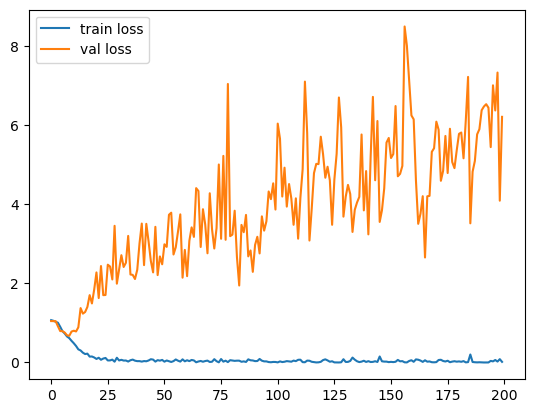

In [36]:
# plot loss and accuracy
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[-29.9732, -52.2975,  51.0452]], device='mps:0',
       grad_fn=<LinearBackward0>)


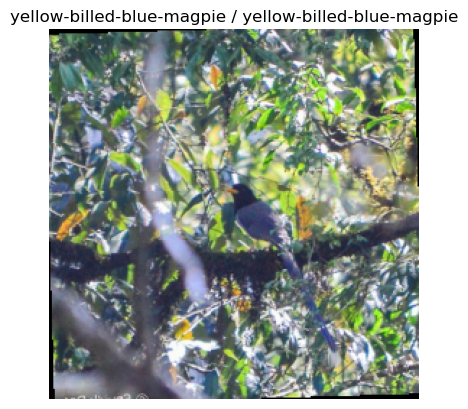

In [83]:
# test model
idx = random.randint(0, len(test_dataset))
x, y = test_dataset[idx]
x = x.unsqueeze(0).to(device)
y_hat = model(x)
print(y_hat)
_, predicted = torch.max(y_hat, 1)
imshow(x[0].cpu(), y, predicted.item())